In [1]:
#!pip install workalendar

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 0. Data Loading

In [33]:
df = pd.read_csv('transactions_n100000.csv')

In [3]:
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234


In [4]:
df.dtypes

ticket_id           object
order_timestamp     object
location             int64
item_name           object
item_count           int64
lat                float64
long               float64
dtype: object

## 1. Preprocessing
### 1.1 Extract information from date

In [34]:
df2 = df.values #to change df2 from dataframe to np.array
df2

array([['0x872a40', '2019-02-28 18:33:00', 4, ..., 2, 41.889047,
        -87.803605],
       ['0x872a40', '2019-02-28 18:33:00', 4, ..., 2, 41.889047,
        -87.803605],
       ['0x872a40', '2019-02-28 18:33:00', 4, ..., 2, 41.889047,
        -87.803605],
       ...,
       ['0x3c0582', '2019-05-27 17:06:00', 9, ..., 4, 41.524598,
        -87.849468],
       ['0x104597', '2019-12-10 00:25:00', 2, ..., 3, 42.049306,
        -87.677606],
       ['0x104597', '2019-12-10 00:25:00', 2, ..., 3, 42.049306,
        -87.677606]], dtype=object)

In [35]:
from datetime import datetime
from workalendar.usa import core

for i in range(len(df2)):
    #to get the time in a standard format
    date = df2[i][1]
    n_date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    
    
    #to mark whether the order took place on a weekday
    cal = core.UnitedStates()
    wkv = int(cal.is_working_day(n_date))
    df2[i][1] = wkv
    
    #to mark whether the food is for lunch, supper or midnight snack
    if n_date.hour in range(11,17):
        df2[i][2] = 'lunch'
    elif n_date.hour in range(17,21):
        df2[i][2] = 'supper'
    elif n_date.hour in [21, 22, 23, 0, 1]:
        df2[i][2] = 'midnight snack'
    else:
        df2[i][2] = Nah

In [36]:
#change the np.array back to dataframe
newdf = pd.DataFrame(df2,columns = ['ticket_id','workday','time','item_name',
                                   'item_count','lat','long']) 
newdf

,ticket_id,workday,time,item_name,item_count,lat,long
0,0x872a40,1,supper,shake,2,41.889047,-87.803605
1,0x872a40,1,supper,burger,2,41.889047,-87.803605
2,0x872a40,1,supper,fries,2,41.889047,-87.803605
3,0x598eb3,1,lunch,burger,1,41.881818,-87.640234
4,0x598eb3,1,lunch,salad,2,41.881818,-87.640234
...,...,...,...,...,...,...,...
260736,0x3c0582,0,supper,burger,3,41.524598,-87.849468
260737,0x3c0582,0,supper,salad,1,41.524598,-87.849468
260738,0x3c0582,0,supper,fries,4,41.524598,-87.849468
260739,0x104597,1,midnight snack,burger,3,42.049306,-87.677606


In [8]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260741 entries, 0 to 260740
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ticket_id   260741 non-null  object
 1   workday     260741 non-null  object
 2   time        260741 non-null  object
 3   item_name   260741 non-null  object
 4   item_count  260741 non-null  object
 5   lat         260741 non-null  object
 6   long        260741 non-null  object
dtypes: object(7)
memory usage: 13.9+ MB


### 1.2 One Hot Encoding

In [37]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
ohe = OneHotEncoder()
df_transformed = ohe.fit_transform(newdf.iloc[:,2:4]).toarray()

In [39]:
# df_transformed2 = ohe.categories_ 可以用来看出不同类别的名字,这里没用..就记录一下

#to know the meaning of each transformed number
df_transformed2 = ohe.get_feature_names() 
print (df_transformed2)
print (df_transformed)

['x0_lunch' 'x0_midnight snack' 'x0_supper' 'x1_burger' 'x1_fries'
 'x1_salad' 'x1_shake']
[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]]


In [40]:
df_transformed3 = pd.DataFrame (df_transformed, 
                                columns = ['lunch','midnight','supper',
                                           'burger','fries','salad','shake'])
df_transformed3

,lunch,midnight,supper,burger,fries,salad,shake
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
260736,0.0,0.0,1.0,1.0,0.0,0.0,0.0
260737,0.0,0.0,1.0,0.0,0.0,1.0,0.0
260738,0.0,0.0,1.0,0.0,1.0,0.0,0.0
260739,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [41]:
df2 = newdf.drop(['time','item_name'],axis = 1)
df2

,ticket_id,workday,item_count,lat,long
0,0x872a40,1,2,41.889047,-87.803605
1,0x872a40,1,2,41.889047,-87.803605
2,0x872a40,1,2,41.889047,-87.803605
3,0x598eb3,1,1,41.881818,-87.640234
4,0x598eb3,1,2,41.881818,-87.640234
...,...,...,...,...,...
260736,0x3c0582,0,3,41.524598,-87.849468
260737,0x3c0582,0,1,41.524598,-87.849468
260738,0x3c0582,0,4,41.524598,-87.849468
260739,0x104597,1,3,42.049306,-87.677606


In [42]:
df3 = pd.concat((df2,df_transformed3),axis = 1)
order = ['ticket_id','burger','fries','salad','shake','item_count','lunch', 'supper','midnight','workday',
         'lat','long']
df4 = df3[order]
print (df4)

       ticket_id  burger  fries  salad  shake item_count  lunch  supper  \
0       0x872a40     0.0    0.0    0.0    1.0          2    0.0     1.0   
1       0x872a40     1.0    0.0    0.0    0.0          2    0.0     1.0   
2       0x872a40     0.0    1.0    0.0    0.0          2    0.0     1.0   
3       0x598eb3     1.0    0.0    0.0    0.0          1    1.0     0.0   
4       0x598eb3     0.0    0.0    1.0    0.0          2    1.0     0.0   
...          ...     ...    ...    ...    ...        ...    ...     ...   
260736  0x3c0582     1.0    0.0    0.0    0.0          3    0.0     1.0   
260737  0x3c0582     0.0    0.0    1.0    0.0          1    0.0     1.0   
260738  0x3c0582     0.0    1.0    0.0    0.0          4    0.0     1.0   
260739  0x104597     1.0    0.0    0.0    0.0          3    0.0     0.0   
260740  0x104597     0.0    1.0    0.0    0.0          3    0.0     0.0   

        midnight workday        lat       long  
0            0.0       1  41.889047 -87.803605  
1

### 1.3 Combine the same order

In [43]:
num = 0

for i in range(len(df2)):
    for j in [1,2,3,4]:
        if df4.iloc[i,j]:
            df4.iloc[i,j] = df4.iloc[i,5]
            break

df4

,ticket_id,burger,fries,salad,shake,item_count,lunch,supper,midnight,workday,lat,long
0,0x872a40,0.0,0.0,0.0,2.0,2,0.0,1.0,0.0,1,41.889047,-87.803605
1,0x872a40,2.0,0.0,0.0,0.0,2,0.0,1.0,0.0,1,41.889047,-87.803605
2,0x872a40,0.0,2.0,0.0,0.0,2,0.0,1.0,0.0,1,41.889047,-87.803605
3,0x598eb3,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,1,41.881818,-87.640234
4,0x598eb3,0.0,0.0,2.0,0.0,2,1.0,0.0,0.0,1,41.881818,-87.640234
...,...,...,...,...,...,...,...,...,...,...,...,...
260736,0x3c0582,3.0,0.0,0.0,0.0,3,0.0,1.0,0.0,0,41.524598,-87.849468
260737,0x3c0582,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0,41.524598,-87.849468
260738,0x3c0582,0.0,4.0,0.0,0.0,4,0.0,1.0,0.0,0,41.524598,-87.849468
260739,0x104597,3.0,0.0,0.0,0.0,3,0.0,0.0,1.0,1,42.049306,-87.677606


In [44]:
df4 = df4.groupby(['ticket_id','lunch','supper','midnight','workday','lat','long'],
                 as_index=False, sort=False).agg({
    'burger':'sum', 
    'fries':'sum',
    'salad':'sum',
    'shake':'sum',
    'item_count':'sum',
})

df4

,ticket_id,lunch,supper,midnight,workday,lat,long,burger,fries,salad,shake,item_count
0,0x872a40,0.0,1.0,0.0,1,41.889047,-87.803605,2.0,2.0,0.0,2.0,6
1,0x598eb3,1.0,0.0,0.0,1,41.881818,-87.640234,1.0,3.0,2.0,0.0,6
2,0x5646c2,1.0,0.0,0.0,0,41.884490,-87.627059,0.0,3.0,3.0,0.0,6
3,0x4022cf,1.0,0.0,0.0,0,41.889047,-87.803605,0.0,4.0,4.0,0.0,8
4,0x7a39d9,0.0,1.0,0.0,1,41.794132,-88.010140,5.0,5.0,0.0,5.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x75c9e7,0.0,0.0,1.0,0,41.784576,-87.607565,2.0,2.0,0.0,0.0,4
99996,0x66f1df,0.0,0.0,1.0,0,41.784576,-87.607565,1.0,1.0,0.0,0.0,2
99997,0x4e2756,1.0,0.0,0.0,0,41.894202,-87.620965,4.0,4.0,0.0,4.0,12
99998,0x3c0582,0.0,1.0,0.0,0,41.524598,-87.849468,3.0,4.0,1.0,3.0,11


In [45]:
finalcheck = df4


### 1.4 Modify data types 

In [18]:
#change all data types into numeric

df4.info()
df4 = df4.drop(['ticket_id'],axis = 1)
import numpy as np

df4['item_count'] = pd.to_numeric(df4['item_count']) 
df4['workday'] = pd.to_numeric(df4['workday']) 
df4['lat'] = pd.to_numeric(df4['lat']) 
df4['long'] = pd.to_numeric(df4['long']) 

df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   lunch       100000 non-null  float64
 1   supper      100000 non-null  float64
 2   midnight    100000 non-null  float64
 3   workday     100000 non-null  int64  
 4   lat         100000 non-null  float64
 5   long        100000 non-null  float64
 6   burger      100000 non-null  float64
 7   fries       100000 non-null  float64
 8   salad       100000 non-null  float64
 9   shake       100000 non-null  float64
 10  item_count  100000 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 9.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   lunch       100000 non-null  float64
 1   supper      100000 non-null  float64
 2   midnight   

### 1.5 Normalization

In [19]:
#normalization
order = ['lunch','supper','midnight','workday','lat','long','burger','fries','salad','shake','total']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df4 = pd.DataFrame(scaler.fit_transform(df4),columns = order)

df4

,lunch,supper,midnight,workday,lat,long,burger,fries,salad,shake,total
0,0.0,1.0,0.0,1.0,0.694575,0.513035,0.4,0.25,0.0,0.4,0.307692
1,1.0,0.0,0.0,1.0,0.680798,0.918850,0.2,0.50,0.4,0.0,0.307692
2,1.0,0.0,0.0,0.0,0.685890,0.951577,0.0,0.50,0.6,0.0,0.307692
3,1.0,0.0,0.0,0.0,0.694575,0.513035,0.0,0.75,0.8,0.0,0.461538
4,0.0,1.0,0.0,1.0,0.513684,0.000000,1.0,1.00,0.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,1.0,0.0,0.495472,1.000000,0.4,0.25,0.0,0.0,0.153846
99996,0.0,0.0,1.0,0.0,0.495472,1.000000,0.2,0.00,0.0,0.0,0.000000
99997,1.0,0.0,0.0,0.0,0.704399,0.966714,0.8,0.75,0.0,0.8,0.769231
99998,0.0,1.0,0.0,0.0,0.000000,0.399111,0.6,0.75,0.2,0.6,0.692308


## 2. Clustering

### 2.1 Selecting k with the Elbow Method

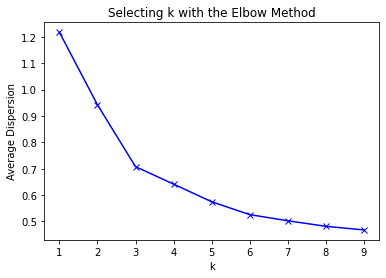

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

K = range(1, 10)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df4)
    meandistortions.append(sum(np.min(cdist(df4, kmeans.cluster_centers_, 'euclidean'), axis=1))/df4.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

#### The best k is 3 !!

### 2.2 Fit the model with k=3

In [21]:
km = KMeans(n_clusters = 3)
km.fit(df4)
label = km.labels_
center = km.cluster_centers_
print(label)

[1 0 0 ... 0 1 2]


In [22]:
print(center.round(3))

[[ 1.    -0.     0.     0.687  0.652  0.847  0.091  0.323  0.368  0.046
   0.216]
 [ 0.021  0.978  0.001  0.688  0.461  0.432  0.688  0.662  0.042  0.651
   0.658]
 [-0.    -0.     1.     0.687  0.708  0.86   0.349  0.206  0.016  0.067
   0.153]]


In [23]:
type(center.round(3))

numpy.ndarray

In [24]:
df4['labels']=km.labels_
df4

,lunch,supper,midnight,workday,lat,long,burger,fries,salad,shake,total,labels
0,0.0,1.0,0.0,1.0,0.694575,0.513035,0.4,0.25,0.0,0.4,0.307692,1
1,1.0,0.0,0.0,1.0,0.680798,0.918850,0.2,0.50,0.4,0.0,0.307692,0
2,1.0,0.0,0.0,0.0,0.685890,0.951577,0.0,0.50,0.6,0.0,0.307692,0
3,1.0,0.0,0.0,0.0,0.694575,0.513035,0.0,0.75,0.8,0.0,0.461538,0
4,0.0,1.0,0.0,1.0,0.513684,0.000000,1.0,1.00,0.0,1.0,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,1.0,0.0,0.495472,1.000000,0.4,0.25,0.0,0.0,0.153846,2
99996,0.0,0.0,1.0,0.0,0.495472,1.000000,0.2,0.00,0.0,0.0,0.000000,2
99997,1.0,0.0,0.0,0.0,0.704399,0.966714,0.8,0.75,0.0,0.8,0.769231,0
99998,0.0,1.0,0.0,0.0,0.000000,0.399111,0.6,0.75,0.2,0.6,0.692308,1


### 2.3 PCA and Visualization

In [25]:
new_df=df4[:]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_pca = pd.DataFrame(pca.fit_transform(new_df))

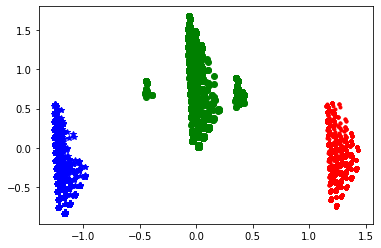

In [26]:
d = new_pca[new_df['labels'] == 0]
plt.plot(d[0], d[1], 'r.')
d = new_pca[new_df['labels'] == 1]
plt.plot(d[0], d[1], 'go')
d = new_pca[new_df['labels'] == 2]
plt.plot(d[0], d[1], 'b*')
plt.gcf().savefig('kmeans.png')
plt.show()

### 2.4 Find the representative of each cluster

In [27]:
newdf4 = df4.drop(['labels'],axis=1)
newdf4

,lunch,supper,midnight,workday,lat,long,burger,fries,salad,shake,total
0,0.0,1.0,0.0,1.0,0.694575,0.513035,0.4,0.25,0.0,0.4,0.307692
1,1.0,0.0,0.0,1.0,0.680798,0.918850,0.2,0.50,0.4,0.0,0.307692
2,1.0,0.0,0.0,0.0,0.685890,0.951577,0.0,0.50,0.6,0.0,0.307692
3,1.0,0.0,0.0,0.0,0.694575,0.513035,0.0,0.75,0.8,0.0,0.461538
4,0.0,1.0,0.0,1.0,0.513684,0.000000,1.0,1.00,0.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,1.0,0.0,0.495472,1.000000,0.4,0.25,0.0,0.0,0.153846
99996,0.0,0.0,1.0,0.0,0.495472,1.000000,0.2,0.00,0.0,0.0,0.000000
99997,1.0,0.0,0.0,0.0,0.704399,0.966714,0.8,0.75,0.0,0.8,0.769231
99998,0.0,1.0,0.0,0.0,0.000000,0.399111,0.6,0.75,0.2,0.6,0.692308


In [28]:
result_pairs = []

distmin = 10

for i in range(3):
    distmin = 10
    n = 0
    
    for j in range(10000):
        dist = np.sqrt(np.sum(np.square(center[i] - np.array(newdf4.iloc[j]))))
        if dist < distmin:
            distmin = dist
            n = j
            
    result_pairs.append((i,n,distmin))

result_pairs

[(0, 277, 0.35328116396347525),
 (1, 661, 0.42999253137731613),
 (2, 400, 0.33344452549441317)]

In [46]:
finalcheck.iloc[661]

ticket_id      0x678652
lunch               0.0
supper              1.0
midnight            0.0
workday               1
lat           41.889047
long         -87.803605
burger              4.0
fries               4.0
salad               0.0
shake               3.0
item_count           11
Name: 661, dtype: object

In [47]:
finalcheck.iloc[277]

ticket_id      0x3dff8a
lunch               1.0
supper              0.0
midnight            0.0
workday               1
lat           41.881818
long         -87.640234
burger              0.0
fries               2.0
salad               2.0
shake               0.0
item_count            4
Name: 277, dtype: object

In [48]:
finalcheck.iloc[400]

ticket_id      0x8f06d6
lunch               0.0
supper              0.0
midnight            1.0
workday               1
lat           41.881818
long         -87.640234
burger              2.0
fries               2.0
salad               0.0
shake               0.0
item_count            4
Name: 400, dtype: object

## 3. Validation

In [ ]:
from sklearn.metrics import silhouette_score
print(silhouette_score(df4, km.labels_, metric='euclidean'))